In [2]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

In [103]:
tables = pd.read_html("NHL_2024_games.html", extract_links="body")
len(tables)

2

<IPython.core.display.Javascript object>

In [104]:
columns = {"G": "GV", "G.1": "GH", "Unnamed: 6": "OT"}
games = tables[0].rename(columns=columns)
games.head()

,Date,Time,Visitor,GV,Home,GH,OT,Att.,LOG,Notes
0,"(2023-10-10, /boxscores/202310100PIT.html)","(8:00 PM, None)","(Chicago Blackhawks, /teams/CHI/2024.html)","(4, None)","(Pittsburgh Penguins, /teams/PIT/2024.html)","(2, None)","(, None)","(18,411, None)","(2:34, None)","(, None)"
1,"(2023-10-10, /boxscores/202310100TBL.html)","(5:30 PM, None)","(Nashville Predators, /teams/NSH/2024.html)","(3, None)","(Tampa Bay Lightning, /teams/TBL/2024.html)","(5, None)","(, None)","(19,092, None)","(2:33, None)","(, None)"
2,"(2023-10-10, /boxscores/202310100VEG.html)","(10:30 PM, None)","(Seattle Kraken, /teams/SEA/2024.html)","(1, None)","(Vegas Golden Knights, /teams/VEG/2024.html)","(4, None)","(, None)","(18,724, None)","(2:22, None)","(, None)"
3,"(2023-10-11, /boxscores/202310110BOS.html)","(7:30 PM, None)","(Chicago Blackhawks, /teams/CHI/2024.html)","(1, None)","(Boston Bruins, /teams/BOS/2024.html)","(3, None)","(, None)","(17,850, None)","(2:29, None)","(, None)"
4,"(2023-10-11, /boxscores/202310110CAR.html)","(7:00 PM, None)","(Ottawa Senators, /teams/OTT/2024.html)","(3, None)","(Carolina Hurricanes, /teams/CAR/2024.html)","(5, None)","(, None)","(18,893, None)","(2:33, None)","(, None)"


<IPython.core.display.Javascript object>

In [127]:
len(games)

1312

<IPython.core.display.Javascript object>

In [115]:
total_map = {}

for i, row in games.iterrows():
    date, link = row["Date"]
    GV, _ = row["GV"]
    GH, _ = row["GH"]
    filename = basename(link)
    total_map[filename] = int(GV) + int(GH)

<IPython.core.display.Javascript object>

In [128]:
from urllib.parse import urljoin
from time import sleep

base_url = "https://www.hockey-reference.com/leagues/NHL_2024_games.html"

for date, link in games["Date"]:
    url = urljoin(base_url, link)
    filename = basename(url)
    if not exists(filename):
        download(url)
        sleep(12)

Downloaded 202404020NSH.html
Downloaded 202404020NYI.html
Downloaded 202404020VEG.html
Downloaded 202404030ARI.html
Downloaded 202404030DAL.html
Downloaded 202404030LAK.html
Downloaded 202404030NYR.html
Downloaded 202404030TOR.html
Downloaded 202404040CAR.html
Downloaded 202404040CBJ.html
Downloaded 202404040MIN.html
Downloaded 202404040MTL.html
Downloaded 202404040NSH.html
Downloaded 202404040OTT.html
Downloaded 202404040SJS.html
Downloaded 202404040WPG.html
Downloaded 202404040WSH.html
Downloaded 202404050ANA.html
Downloaded 202404050ARI.html
Downloaded 202404050BUF.html
Downloaded 202404050CAR.html
Downloaded 202404050DET.html
Downloaded 202404050EDM.html
Downloaded 202404060BOS.html
Downloaded 202404060CBJ.html
Downloaded 202404060CGY.html
Downloaded 202404060CHI.html
Downloaded 202404060LAK.html
Downloaded 202404060MIN.html
Downloaded 202404060MTL.html
Downloaded 202404060NYI.html
Downloaded 202404060OTT.html
Downloaded 202404060PIT.html
Downloaded 202404060SJS.html
Downloaded 202

<IPython.core.display.Javascript object>

In [130]:
from bs4 import BeautifulSoup


def read_scoring_table(filename):
    # Load the HTML content from a file
    with open(filename, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, "lxml")

    # Find the table with the specific attribute
    table = soup.find("table", {"id": "scoring"})

    # Extract the table data
    if table:
        # Get the rows of the table
        rows = []
        for row in table.find_all("tr"):
            columns = row.find_all(["td", "th"])
            row_data = [column.text.strip() for column in columns]
            rows.append(row_data)

        return rows
    else:
        print('Table with data-label="Scoring Summary" not found.')

<IPython.core.display.Javascript object>

In [131]:
def get_times(rows):
    offset = 0
    times = []

    for row in rows:
        element = row[0]
        if element == "1st Period":
            offset = 0
            continue

        if element == "2nd Period":
            offset = 20
            continue

        if element == "3rd Period":
            offset = 40
            continue

        if element.endswith("OT Period"):
            break

        if element in ["Shootout"]:
            break

        if element in ["2nd Period", "3rd Period"]:
            offset += 20

        else:
            minutes, seconds = map(int, element.split(":"))
            minutes += offset
            total_seconds = minutes * 60 + seconds
            times.append(total_seconds)

    times = np.array(times)
    assert np.all(times <= 3600)
    assert np.all(np.diff(times) > 0)
    assert len(times) <= total_map[filename]
    return times

<IPython.core.display.Javascript object>

In [132]:
from glob import glob

filenames = glob("202*.html")
len(filenames)

1312

<IPython.core.display.Javascript object>

In [138]:
!rm nhl_2023_2024.hdf

<IPython.core.display.Javascript object>

In [133]:
import shelve

with shelve.open("times.db") as db:

    for filename in sorted(filenames):
        rows = read_scoring_table(filename)
        times = get_times(rows)
        print(filename, times)
        db[filename] = times

202310100PIT.html [ 424 1916 2137 3005 3329 3513]
202310100TBL.html [ 588 2175 2411 2545 2587 2928 3052 3598]
202310100VEG.html [ 436  897 1280 1699 3525]
202310110BOS.html [ 337  682 1989 3544]
202310110CAR.html [ 194 1375 2277 2420 2714 2749 2871 3065]
202310110CGY.html [ 749  888 1070 1879 2029 3258 3508 3593]
202310110LAK.html [ 445 1374 1427 1578 2395 2699 3368]
202310110TOR.html [ 181 1270 1666 2091 2355 2665 2747 3115 3328 3533]
202310110VAN.html [ 486  687 1443 1650 1700 1868 2743 2816 3288]
202310120BUF.html [ 227  742 1969 2310 3094 3511]
202310120CBJ.html [ 213  504  763 3511 3556 3599]
202310120DAL.html [1218 1357]
202310120MIN.html [ 474 1976]
202310120NJD.html [1934 2019 2323 3043 3337 3509 3566]
202310120NSH.html [1824 3003 3499]
202310120SJS.html [ 925 1068 2311 2364 2531]
202310130NJD.html [ 382 1463 1689 1949 2333 3235]
202310130WSH.html [1447 1551 1906 3417]
202310140BOS.html [ 209  888 2086 2214 2572]
202310140CBJ.html [  50  576 1065 1950 2017 3053 3354 3564]
20231

202311040PHI.html [ 872  890 2161 2384 2792]
202311040SEA.html [ 596  839  982 2340 2493 2640 3509 3552 3579]
202311040SJS.html [  90  775 1401 1466 1714 1752 1767 1913 2449 2960 3062 3130]
202311040STL.html [  84  241  997 1983 2088 2570 2753 3360 3512]
202311040TOR.html [ 725  973 1588 1882 1916 2417 2591 2846 3168 3534]
202311040VAN.html [1461 2154]
202311040VEG.html [1010 1775 1977 2029 2602 2953 3283]
202311040WSH.html [ 741 1041 1298]
202311050ANA.html [ 531 2023 2498 3055 3380 3531]
202311050CHI.html [ 111  787  881 2675 3314 3599]
202311060DAL.html [ 621  849 2709 2991 3572]
202311060FLA.html [ 139  189  369  941 1131 1802 3150 3543]
202311060TOR.html [ 222  257  371  687  913 1342 1542 2515 2523 3454]
202311060VAN.html [ 402  690  802  892 1658 1852 2871 3544]
202311070ANA.html [ 754 3580]
202311070ARI.html [  40  367 1439 1497 2476 2518]
202311070CAR.html [ 763 1431 2874 2963]
202311070CGY.html [ 275  874 2106 2685 2784 3501]
202311070COL.html [ 223  950 1345 1864 1905 2104 2

202311280ARI.html [ 201 1542 2122 2842]
202311280CHI.html [ 534  623  883 1163 1462 1843 2811]
202311280EDM.html [ 809 1271 1508 1551 1674 2243 3210 3472]
202311280MIN.html [ 161  630 1090 3428]
202311280NJD.html [ 316  629 1459 1704 1780 1985 2708 3070 3577]
202311280NSH.html [ 620 1118 1549 2546]
202311280PHI.html [ 339 1634 2005 3394 3436]
202311280TOR.html [ 929 1974]
202311280VAN.html [ 394 1510 2432 3552]
202311280WPG.html [1974 3405]
202311290CBJ.html [1420 1656 1787 2048 3423 3543]
202311290LAK.html [ 544  732 2310]
202311290NYR.html [1477 1723 1746 2954 3345]
202311300ANA.html [  87  109  471  954 1119 1139 3105 3262 3572]
202311300ARI.html [1171 1383 1484 2182 2468 3064]
202311300BOS.html [1299 1690 2797]
202311300CAR.html [ 488 1080 1321 2159 2283 2439 2801 3597]
202311300CGY.html [ 291  482  930 1140 2509 3439]
202311300DET.html [ 149  200  522 1509 1556 3054]
202311300MTL.html [1627 2408 2592 2749 2970 3589]
202311300NSH.html [ 368  841  872 1303 1872 2557 2987]
202311300P

202312190TBL.html [ 143 1030 1186 1296 1933 2873 3357]
202312190TOR.html [1571 1652 1790 2476 2888 3308 3407]
202312200LAK.html [1519 2787 2880]
202312200WPG.html [ 938 1304 1661 1850 2170 2921 3312]
202312200WSH.html [ 596 1263 1992 3122]
202312210ANA.html [ 144 1669 3480]
202312210BUF.html [ 147  448  759  824  951 1484 1542 1702 1864 3068 3143 3302]
202312210CBJ.html [1104 2118 2244 3169]
202312210COL.html [ 163  913  928 1108 1292 2087 2383 2776 2830 3577]
202312210DAL.html [ 171  651 1671 1946 3304 3390]
202312210FLA.html [1490 1666 2027 2203 3411]
202312210MIN.html [ 799  894 1697 2469 2937 3417]
202312210NJD.html [  24  324  794 1299 2186 2500 2542 2569 2944]
202312210PHI.html [  91 1265 1485 1524 3359 3599]
202312210PIT.html [ 531 2092]
202312210SJS.html [1498 1580 1710 1976 2426 2865 3170]
202312210TBL.html [ 700 1018 1705 2155 2188 2330 2731 2984 3527]
202312220CHI.html [1016 1423 1460 2102 2253 3191 3484]
202312220DET.html [ 270  496  540  905  938 1182 1417 1441 2751 3210 3

202401130DET.html [ 164  418 1757 2182 2246 2387 2587 2738]
202401130FLA.html [ 230  885 1431 2367 3581]
202401130MIN.html [ 307  707 1041 1311 1600 2438]
202401130MTL.html [ 103 2438]
202401130NSH.html [3120 3308 3592 3599]
202401130OTT.html [ 252  598  755 1433 1580 1631 1979 3416 3595]
202401130STL.html [ 302  367 1586 1857 2863 3287]
202401130TBL.html [1509 1856 2000 2087 2946 3485]
202401130TOR.html [ 383  647  904 1527 1993 2855 3395 3593]
202401130VEG.html [ 666  784 2229 2934]
202401130WPG.html [ 887 1372]
202401130WSH.html [ 803 1070 1515 2796 2909]
202401140NYR.html [  50 1150 1863]
202401140TOR.html [1232 2139 2298 2566 3500 3581]
202401150BOS.html [1230 2602 3522]
202401150BUF.html [1894 2077 3394]
202401150CAR.html [ 384 1538 2461 2541 2720 2938 3524]
202401150CBJ.html [ 328  355  894 1408 1655 3057]
202401150FLA.html [ 509 1055 1196 1524 1776 1969 2098 2625]
202401150MIN.html [ 131 1338 2016 3369 3543]
202401150MTL.html [ 268  437 1261 2168 2512 2977 3350]
202401150PIT.ht

202402130MTL.html [1303 1777 2220 2846 3435]
202402130NSH.html [ 244 1290 1621 2536 3284 3561]
202402130NYI.html [ 327 2077]
202402130OTT.html [ 431  588  636  886 1537 1841 2034 2208 3592]
202402130TOR.html [ 333  985 1536 2882 3501]
202402130WSH.html [ 166  297  556  600 1730 2223 2940 3541 3567]
202402140ARI.html [ 841 2379 2721 3064]
202402140PIT.html [1468 1502 1707 1982 2124 2735 2767]
202402140WPG.html [1067]
202402150BOS.html [ 294  551 2255 2916 3581]
202402150BUF.html [ 566 2236 3507 3588]
202402150CGY.html [ 259 1492 1670 1950 2380 2678 2715 3330 3400]
202402150CHI.html [  15  760 1702 2751 3550]
202402150NJD.html [1687 1978 3263]
202402150NSH.html [  35  267  751  953 1480 1790 1851 1881 2387 2630 2930]
202402150NYR.html [ 869 1869 1947 2083 2119 2190 2663 2813 2879 2996 3087]
202402150OTT.html [ 559 2245 2339 2538 2683 2963]
202402150STL.html [ 613  831 1173 1269 1717 2132 2375 3074 3427]
202402150TBL.html [ 908 1038 1105 2103 2620 2640 2893 3568 3574]
202402150TOR.html [ 

202403050WPG.html [ 525 1687 2276 2391 2477 2502 3441]
202403060ANA.html [ 164 1482 2607]
202403060COL.html [ 108  315  810 1027 1729 2172 2366 2832 3325]
202403060TOR.html [1349 1591]
202403070ARI.html [1311 2481 2488 2520 2836 3528 3573]
202403070BOS.html [ 337 1456 1676 2236 2303]
202403070CAR.html [ 353  782 2375 3331 3537]
202403070CBJ.html [ 380  894  921 1271 3128 3580]
202403070FLA.html [1210 1632 3578]
202403070LAK.html [ 453 2004 2019 3024 3106 3337]
202403070NJD.html [ 804  964 1743 2200 3541]
202403070NSH.html [ 233  263  975 2509 2803 3172]
202403070PIT.html [ 111 1230 1396 1730 2181 2533]
202403070SJS.html [  19 1111 1365 1884 1909 1924 2061 2185 2888]
202403070TBL.html [ 700  868 1571 1714 1765 1949 2764 3137 3275]
202403070VEG.html [ 361  416 1430 2158]
202403080ANA.html [  74 1039 1136 1531 1566 2058 2653 2838]
202403080ARI.html [ 155  485 1024 1696]
202403080COL.html [  42 1844]
202403080SEA.html [2835 3088 3550]
202403090BOS.html [1346 1968 2305 2571 2976 3333]
20240

202403280MIN.html [ 961 1766 2418 3546]
202403280MTL.html [ 778 1006 3425 3539 3596]
202403280OTT.html [ 36 368]
202403280PIT.html [1520 1790 1991 2171 2435]
202403280SEA.html [1743 2528 2572 2785 3183 3335]
202403280STL.html [ 782  888 1117 1407 1734 2210 2524 3525]
202403280TOR.html [ 609 1218 1527 1898 2466 3011]
202403280VAN.html [1128 1659 3412 3477]
202403280WPG.html [ 956 1411 3271 3495 3566]
202403290BUF.html [ 180  631 1228 2249 3326 3562 3594]
202403300ARI.html [ 855 1319 1587 1605 1866 2358 2745 2836 2973 3141 3266 3455 3585]
202403300BUF.html [ 298 1354 3263]
202403300CBJ.html [ 467 2009 2335 2939 2948 3107]
202403300CGY.html [ 285  342  716 1918 2305 3090]
202403300COL.html [ 221  325  782  823  971 1257 1543 2305 2371 2618 3370]
202403300EDM.html [ 227  855  976 1768 2157 2826 3342]
202403300FLA.html [ 631 3141 3304 3360]
202403300MIN.html [2204 3223]
202403300MTL.html [1773 2622 3432]
202403300PHI.html [ 121 1020 1217 2248 2949 3273]
202403300SEA.html [2292 2428 3523]
20

<IPython.core.display.Javascript object>

In [140]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()
len(keys)

1312

<IPython.core.display.Javascript object>

In [141]:
all_times = pd.concat([pd.read_hdf(filename, key=key) for key in keys])

/tmp/ipykernel_4324/1341657598.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_times = pd.concat([pd.read_hdf(filename, key=key) for key in keys])


<IPython.core.display.Javascript object>

In [147]:
from empiricaldist import Pmf

pmf_minutes = Pmf.from_seq(all_times // 60 + 0.5)

<IPython.core.display.Javascript object>

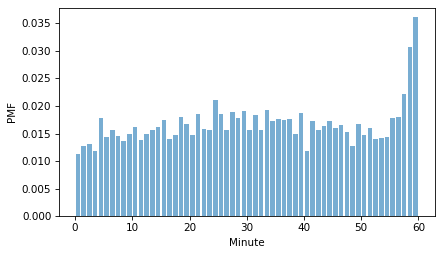

<IPython.core.display.Javascript object>

In [153]:
pmf_minutes.bar(alpha=0.6)
decorate(xlabel="Minute", ylabel="PMF")